In [12]:
from __future__ import print_function #Python 2.7 compatibility
from srwlib import *
from srwl_uti_smp import *
from uti_plot import * #required for plotting
import copy, os, sys, time
import numpy as np
import pylab as plt

In [13]:
#**********************Input Parameters and Structures
#***********Folder and Data File Names
strDataFolderName = 'data_demo' #data sub-folder name
strIntInitOutFileName01 = 'demo_res_int_in_time.dat' #initial wavefront intensity distribution output file name
strIntPropOutFileName01 = 'demo_res_int_after_CRL0_time.dat' #propagated wavefront intensity distribution output file name
strIntPropOutFileName02 = 'demo_res_int_after_C1_time.dat'

#***********Gaussian Beam Source
GsnBm = SRWLGsnBm() #Gaussian Beam structure (just parameters)
GsnBm.x = 0 #Transverse Positions of Gaussian Beam Center at Waist [m]
GsnBm.y = 0
GsnBm.z = 630. #Longitudinal Position of Waist [m]
GsnBm.xp = 0 #Average Angles of Gaussian Beam at Waist [rad]
GsnBm.yp = 0
GsnBm.avgPhotEn = 9481 #Photon Energy [eV]
GsnBm.pulseEn = 0.001 #Energy per Pulse [J] - to be corrected
GsnBm.repRate = 1 #Rep. Rate [Hz] - to be corrected
GsnBm.polar = 1 #1- linear horizontal
GsnBm.sigX = 23.e-6/2.35 #Horiz. RMS size at Waist [m]
GsnBm.sigY = GsnBm.sigX #Vert. RMS size at Waist [m]

constConvRad = 1.23984186e-06/(4*3.1415926536)
rmsAngDiv = constConvRad/(GsnBm.avgPhotEn*GsnBm.sigX) #RMS angular divergence [rad]
print('RMS Source Size:', round(GsnBm.sigX*1.e+06, 3), 'um; RMS Divergence:', round(rmsAngDiv*1.e+06, 3), 'urad')

GsnBm.sigT = 400e-15 #Pulse duration [fs] (not used?)
GsnBm.mx = 0 #Transverse Gauss-Hermite Mode Orders
GsnBm.my = 0

#***********Initial Wavefront
wfr = SRWLWfr() #Initial Electric Field Wavefront
wfr.allocate(100, 100, 100) #Numbers of points vs Photon Energy (1), Horizontal and Vertical Positions (dummy)
wfr.mesh.zStart = GsnBm.z + 290. #Longitudinal Position [m] at which initial Electric Field has to be calculated, i.e. the position of the first optical element
wfr.mesh.eStart = GsnBm.avgPhotEn-1e-3 #Initial Photon Energy [eV]
wfr.mesh.eFin = GsnBm.avgPhotEn+1e-3 #Final Photon Energy [eV]
wfr.unitElFld = 1 #Electric field units: 0- arbitrary, 1- sqrt(Phot/s/0.1%bw/mm^2), 2- sqrt(J/eV/mm^2) or sqrt(W/mm^2), depending on representation (freq. or time)

#Horizontal and Vertical Position Range for the Initial Wavefront calculation
firstHorAp = 3e-3 #[m]
firstVertAp = firstHorAp #[m]
wfr.mesh.xStart = -0.5*firstHorAp #Initial Horizontal Position [m]
wfr.mesh.xFin = 0.5*firstHorAp #Final Horizontal Position [m]
wfr.mesh.yStart = -0.5*firstVertAp #Initial Vertical Position [m]
wfr.mesh.yFin = 0.5*firstVertAp #Final Vertical Position [m]

sampFactNxNyForProp = 3 #sampling factor for adjusting nx, ny (effective if > 0)
arPrecPar = [sampFactNxNyForProp]

wfr.partBeam.partStatMom1.x = GsnBm.x #Some information about the source in the Wavefront structure
wfr.partBeam.partStatMom1.y = GsnBm.y
wfr.partBeam.partStatMom1.z = GsnBm.z
wfr.partBeam.partStatMom1.xp = GsnBm.xp
wfr.partBeam.partStatMom1.yp = GsnBm.yp

#***********Detector
npx = 80 #Detector Number of Pixels in Horizontal direction
npy = 80 #Detector Number of Pixels in Vertical direction
pSize = 50e-06 #Detector Pizel Size
xrDet = npx*pSize
yrDet = npy*pSize
det = SRWLDet(_xStart = -0.5*xrDet, _xFin = 0.5*xrDet, _nx = npx, _yStart = -0.5*yrDet, _yFin = 0.5*yrDet, _ny = npy)

#***********Optics
#energy dependent refractive index calculation
def get_refractive_index(axis_ev, ekev):
    def E2L(e):
        hbar = 6.582119569e-16
        omega = e/hbar
        frequency = omega /2/np.pi
        wavelength = 3e8/frequency
        return wavelength
    def E2k(e):
        wavelength = E2L(e)
        k = 2*np.pi/wavelength
        return k
    cxro_data = np.genfromtxt('Be.csv',delimiter=',')
    ev = cxro_data[:,0]
    delta = cxro_data[:,1]
    beta = cxro_data[:,2]
    
    delta1 = np.interp(axis_ev, ev, delta)
    beta1 = np.interp(axis_ev, ev, beta)
    atten_len1 = 1/beta1/E2k(ekev*1e3)
    return delta1.tolist(), atten_len1.tolist()

axis_ev = np.linspace(wfr.mesh.eStart, wfr.mesh.eFin, wfr.mesh.ne)
delta, atten_len = get_refractive_index(axis_ev, 9.481)

opCRL0 = srwl_opt_setup_CRL(_foc_plane=3, _delta=delta, _atten_len=atten_len,
                          _shape=1, _apert_h=2e-3, _apert_v=2e-3,
                          _r_min=2.1989112772e-3, _n=1, _wall_thick=5e-5,
                          _xc=0.0, _yc=0.0, _e_start=wfr.mesh.eStart, _e_fin=wfr.mesh.eFin,
                          _nx=1001, _ny=1001)

opCRL1 = srwl_opt_setup_CRL(_foc_plane=3, _delta=delta, _atten_len=atten_len,
                          _shape=1, _apert_h=2e-3, _apert_v=2e-3,
                          _r_min=7.582452680000001e-5, _n=1, _wall_thick=5e-5,
                          _xc=0.0, _yc=0.0, _e_start=wfr.mesh.eStart, _e_fin=wfr.mesh.eFin,
                          _nx=1001, _ny=1001)

opCRL2 = srwl_opt_setup_CRL(_foc_plane=3, _delta=delta, _atten_len=atten_len,
                          _shape=1, _apert_h=2e-3, _apert_v=2e-3,
                          _r_min=7.582452680000001e-5, _n=1, _wall_thick=5e-5,
                          _xc=0.0, _yc=0.0, _e_start=wfr.mesh.eStart, _e_fin=wfr.mesh.eFin,
                          _nx=1001, _ny=1001)

opC1 = SRWLOptCryst(_d_sp=0.9600687344008111,
                  _psi0r=-1.0873035035585694e-05, _psi0i=1.8438837339536554e-07,
                  _psi_hr=-4.181686438547451e-06, _psi_hi=1.6100412693351052e-07,
                  _psi_hbr=-4.181686438547451e-06, _psi_hbi=1.6100412693351052e-07,
                  _tc=0.01, _ang_as=0,
                  _nvx=-0.7322282430733594, _nvy=4.975415277322606e-09, _nvz=-0.6810593219725439,
                  _tvx=-0.6810593219725439, _tvy=4.627727743855522e-09, _uc=1)

opC2 = SRWLOptCryst(_d_sp=0.9600687344008111,
                  _psi0r=-1.0873035035585694e-05, _psi0i=1.8438837339536554e-07,
                  _psi_hr=-4.181686438547451e-06, _psi_hi=1.6100412693351052e-07,
                  _psi_hbr=-4.181686438547451e-06, _psi_hbi=1.6100412693351052e-07,
                  _tc=0.01, _ang_as=-0.6619756915046209,
                  _nvx=0.158940316609, _nvy=1.08e-09, _nvz=-0.987288192858,
                  _tvx=0.987288192858, _tvy=6.709e-09, _uc=1)

opC3 = SRWLOptCryst(_d_sp=0.9600687344008111,
                  _psi0r=-1.0873035035585694e-05, _psi0i=1.8438837339536554e-07,
                  _psi_hr=-4.181686438547451e-06, _psi_hi=1.6100412693351052e-07,
                  _psi_hbr=-4.181686438547451e-06, _psi_hbi=1.6100412693351052e-07,
                  _tc=0.01, _ang_as=0,
                  _nvx=0.732228243073, _nvy=4.975e-09, _nvz=-0.681059321973,
                  _tvx=0.681059321973, _tvy=4.628e-09, _uc=1)

opC4 = SRWLOptCryst(_d_sp=0.9600687344008111,
                  _psi0r=-1.0873035035585694e-05, _psi0i=1.8438837339536554e-07,
                  _psi_hr=-4.181686438547451e-06, _psi_hi=1.6100412693351052e-07,
                  _psi_hbr=-4.181686438547451e-06, _psi_hbi=1.6100412693351052e-07,
                  _tc=0.01, _ang_as=0.6619756915046209,
                  _nvx=-0.996192732149, _nvy=6.769e-09, _nvz=-0.087178210659,
                  _tvx=-0.087178210659, _tvy=5.92e-10, _uc=1)

#nvx, nvy, nvz = opC1.find_orient(GsnBm.avgPhotEn,np.pi/2)[0][2]
#tvx, tvy, _ = opC1.find_orient(GsnBm.avgPhotEn,np.pi/2)[0][0]
#opC1.set_orient(nvx,nvy,nvz,tvx,tvy)

opSlit = SRWLOptA('r', 'a', _Dx=200e-6, _Dy=10e-3, _x=0.0, _y=0.0)

#Drift
opCRL0_Det = SRWLOptD(.1)
opC1_Det = SRWLOptD(.1)
opC2_Det = SRWLOptD(.1)
opCRL1_Det = SRWLOptD(.1)
opSlit_Det = SRWLOptD(.1)
opCRL2_Det = SRWLOptD(.1)
opC3_Det = SRWLOptD(.1)
opC4_Det = SRWLOptD(.1)

opCRL0_C1 = SRWLOptD(10.)
opC1_C2 = SRWLOptD(.2)
opC2_CRL1 = SRWLOptD(10.)
opCRL1_Slit = SRWLOptD(10.)
opSlit_CRL2 = SRWLOptD(10.)
opCRL2_C3 = SRWLOptD(10.)
opC3_C4 = SRWLOptD(.2)

#Wavefront Propagation Parameters:
#[0]: Auto-Resize (1) or not (0) Before propagation
#[1]: Auto-Resize (1) or not (0) After propagation
#[2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]: Allow (1) or not (0) for semi-analytical treatment of the quadratic (leading) phase terms at the propagation
#[4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]: Horizontal Range modification factor at Resizing (1. means no modification)
#[6]: Horizontal Resolution modification factor at Resizing
#[7]: Vertical Range modification factor at Resizing
#[8]: Vertical Resolution modification factor at Resizing
#[9]: Type of wavefront Shift before Resizing
#[10]: New Horizontal wavefront Center position after Shift
#[11]: New Vertical wavefront Center position after Shift

#             [0][1][2] [3][4] [5]  [6]  [7]  [8]  [9] [10] [11]
ppCRL0_Det =  [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppC1_Det =    [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppC2_Det =    [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppCRL1_Det =  [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppSlit_Det =  [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppCRL2_Det =  [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppC3_Det =    [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppC4_Det =    [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]

ppCRL0 =      [0, 0, 1., 0, 0, 4.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppCRL0_C1 =   [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppC1 =        [0, 0, 1., 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppC1_C2 =     [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppC2 =        [0, 0, 1., 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppC2_CRL1 =   [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppCRL1 =      [0, 0, 1., 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppCRL1_Slit = [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppSlit =      [0, 0, 1., 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppSlit_CRL2 = [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppCRL2 =      [0, 0, 1., 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppCRL2_C3 =   [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppC3 =        [0, 0, 1., 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppC3_C4 =     [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppC4 =        [0, 0, 1., 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]

ppFin =       [0, 0, 1., 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]

opBL1 = SRWLOptC([opCRL0, opCRL0_C1, opC1, opC1_C2, opC2,
                  opC2_CRL1, opCRL1, opCRL1_Slit, opSlit, opSlit_CRL2, opCRL2,
                  opCRL2_C3, opC3, opC3_C4, opC4],
                 
                 [ppCRL0, ppCRL0_C1, ppC1, ppC1_C2, ppC2,
                  ppC2_CRL1, ppCRL1, ppCRL1_Slit, ppSlit, ppSlit_CRL2, ppCRL2,
                  ppCRL2_C3, ppC3, ppC3_C4, ppC4, ppFin])


RMS Source Size: 9.787 um; RMS Divergence: 1.063 urad
Optical Element Setup: CRL Focal Length: 290.00000060171766 m
Optical Element Setup: CRL Focal Length: 10.000000020748885 m
Optical Element Setup: CRL Focal Length: 10.000000020748885 m


   Propagating wavefront ... done in 1545 s
   Extracting, projecting propagated wavefront intensity on detector and saving it to file ... done in 16 s
   Plotting the results (blocks script execution; close any graph windows to proceed) ... 

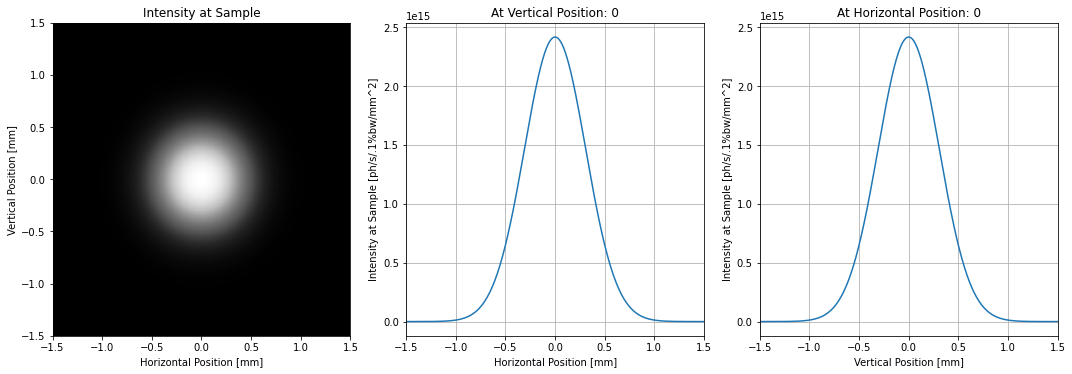

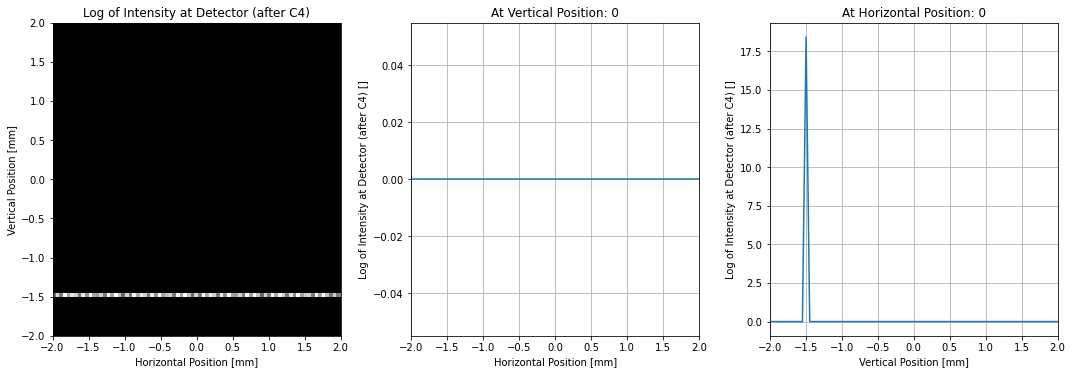

done


In [14]:
#**********************Main Calculations
#***********Initial Wavefront of Gaussian Beam
srwl.CalcElecFieldGaussian(wfr, GsnBm, arPrecPar)
mesh0 = deepcopy(wfr.mesh)
arI0 = array('f', [0]*mesh0.nx*mesh0.ny*mesh0.ne) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arI0, wfr, 6, 0, 3, mesh0.eStart, 0, 0) #extracts intensity

srwl_uti_save_intens_ascii(
    arI0, mesh0, os.path.join(os.getcwd(), strDataFolderName, strIntInitOutFileName01), 0,
    ['Photon Energy', 'Horizontal Position', 'Vertical Position', 'Intensity'], _arUnits=['eV', 'm', 'm', 'ph/s/.1%bw/mm^2'])

#***********Wavefront Propagation (BL1)
wfr1 = deepcopy(wfr)

print('   Propagating wavefront ... ', end='')
t = time.time()
srwl.PropagElecField(wfr1, opBL1)
print('done in', round(time.time() - t), 's')

print('   Extracting, projecting propagated wavefront intensity on detector and saving it to file ... ', end='')
t = time.time()
mesh1 = deepcopy(wfr1.mesh)
arI1 = array('f', [0]*mesh1.nx*mesh1.ny*mesh1.ne) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arI1, wfr1, 6, 0, 3, mesh1.eStart, 0, 0) #extracts intensity

stkDet = det.treat_int(arI1, _mesh = mesh1) #"Projecting" intensity on detector (by interpolation)
mesh1 = stkDet.mesh; arI1 = stkDet.arS
srwl_uti_save_intens_ascii(
    arI1, mesh1, os.path.join(os.getcwd(), strDataFolderName, strIntPropOutFileName01), 0,
    ['Photon Energy', 'Horizontal Position', 'Vertical Position', 'Spectral Fluence'], _arUnits=['eV', 'm', 'm', 'J/eV/mm^2'])
print('done in', round(time.time() - t), 's')

#**********************Plotting Results (requires 3rd party graphics package)
print('   Plotting the results (blocks script execution; close any graph windows to proceed) ... ', end='')
plotMesh0x = [mesh0.xStart, mesh0.xFin, mesh0.nx]
plotMesh0y = [mesh0.yStart, mesh0.yFin, mesh0.ny]
uti_plot2d1d(arI0, plotMesh0x, plotMesh0y, x=0, y=0, labels=['Horizontal Position', 'Vertical Position', 'Intensity at Sample'], units=['m', 'm', 'ph/s/.1%bw/mm^2'])

plotMesh1x = [mesh1.xStart, mesh1.xFin, mesh1.nx]
plotMesh1y = [mesh1.yStart, mesh1.yFin, mesh1.ny]
arLogI1 = copy.copy(arI1)
nTot1 = mesh1.ne*mesh1.nx*mesh1.ny
for i in range(nTot1):
    curI = arI1[i]
    if(curI <= 0.): arLogI1[i] = 0
    else: arLogI1[i] = log(curI)
uti_plot2d1d(arLogI1, plotMesh1x, plotMesh1y, x=0, y=0, labels=['Horizontal Position', 'Vertical Position', 'Log of Intensity at Detector (after C4)'], units=['m', 'm', ''])

uti_plot_show() #show all graphs (blocks script execution; close all graph windows to proceed)
print('done')

R-space
R-space
R-space
R-space


Text(0.5, 1.0, 'spectral response')

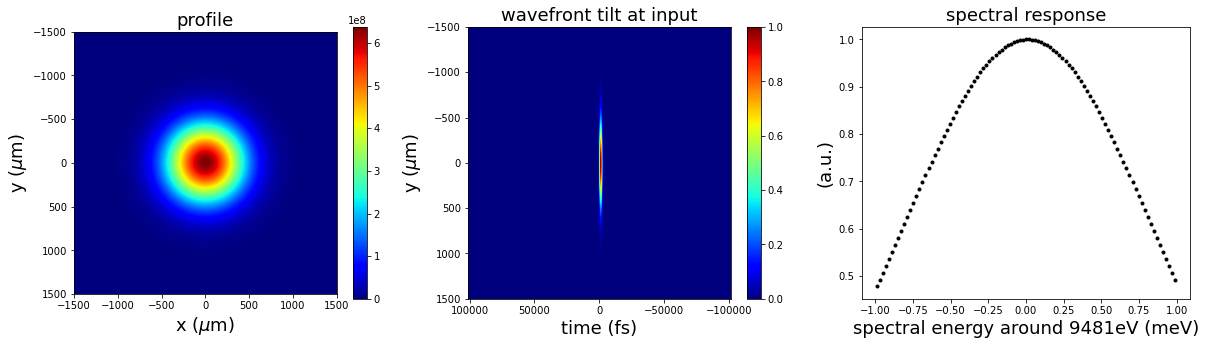

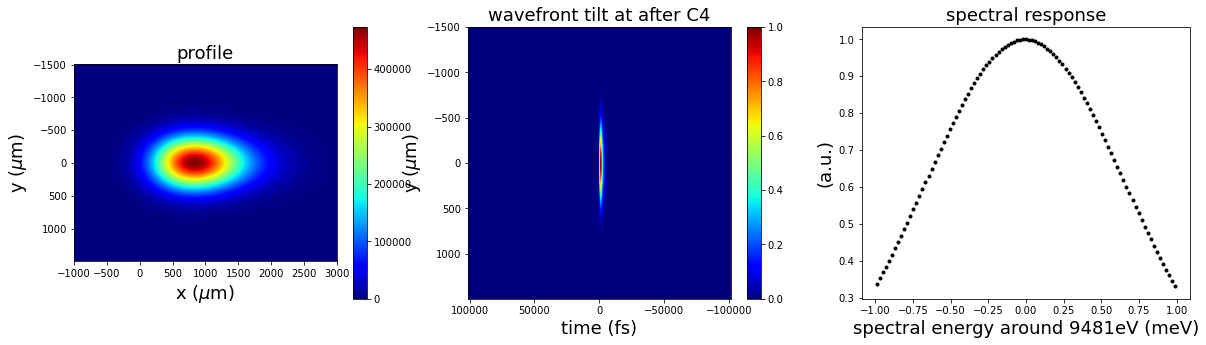

In [39]:
from wpg import Wavefront

def plot_spatial_from_wf(wf):
    srwl.SetRepresElecField(wf._srwl_wf, 't')
    [xmin, xmax, ymin, ymax] = wf.get_limits()
    img = wf.get_intensity().sum(axis=-1)
    plt.imshow(img,cmap='jet',
        extent = [xmin*1e6, xmax*1e6, ymin*1e6, ymax*1e6])
    plt.colorbar()
    plt.xlabel(r'x ($\mu$m)',fontsize=18)
    plt.ylabel(r'y ($\mu$m)',fontsize=18)

def get_temporal(wf):
    # change the wavefront into time domain, where each slice in z represent a time
    srwl.SetRepresElecField(wf._srwl_wf, 't')
    mesh = wf.params.Mesh
    dx = (mesh.xMax - mesh.xMin) / (mesh.nx - 1)        # spatial sampling resolution
    dy = (mesh.yMax - mesh.yMin) / (mesh.ny - 1)
    int0 = wf.get_intensity().sum(axis=0).sum(axis=0)   # intensity per slice
    #int0_00 = wf.get_intensity()[int(mesh.ny/2), int(mesh.nx/2),:]  # central intensity
    dSlice = (mesh.sliceMax - mesh.sliceMin)/(mesh.nSlices-1)   # time sampling resolution
    axis_t = np.arange(mesh.nSlices) * dSlice + mesh.sliceMin  # time axis

    # get meaningful slices (>1% maximum intensity)
    int0max = max(int0)                                 # maximum intensity slice
    aw = [a[0] for a in np.argwhere(int0>int0max*0.01)] # meaningful indices
    aw = np.asarray(aw)
    #int0_mean = int0[min(aw):max(aw)]                   # meaningful intensity slices
    #axis_t = np.arange(min(aw),max(aw)) * dSlice + mesh.sliceMin # meaningful time axis
    return aw, axis_t, int0

def get_tilt(wf, ori='V'):
    srwl.SetRepresElecField(wf._srwl_wf, 't')
    [xmin, xmax, ymin, ymax] = wf.get_limits()
    mesh = wf.params.Mesh
    if ori == 'V':
        axis = np.linspace(ymin, ymax, mesh.ny)
        tilt = wf.get_intensity()[:,int(mesh.nx/2),:]
    else:
        axis = np.linspace(xmin, xmax, mesh.nx)
        tilt = wf.get_intensity()[int(mesh.ny/2),:,:]
    return axis, tilt

def plot_tilt(axis, tilt, axis_t, label=None, ori='V', if_log=0):
    tilt = tilt/tilt.max()
    tilt = tilt + 1e-30
    if ori == 'V':
        alabel = 'y'
    else:
        alabel = 'x'
    title = 'wavefront tilt at '+label
    if if_log == 1:
        tilt = np.log(tilt)
        title = title+', log'
    plt.imshow(tilt, cmap='jet',
              extent = [axis_t.max()*1e15, axis_t.min()*1e15, axis.max()*1e6, axis.min()*1e6])
    plt.colorbar()
    if if_log == 1:
        cmin = np.max(tilt)-10
        plt.clim(cmin)
    plt.axis('tight')
    plt.title(title, fontsize=18)
    plt.xlabel('time (fs)', fontsize=18)
    plt.ylabel(alabel+r' ($\mu$m)', fontsize=18)

def plot_tilt_from_wf(wf, label=None, ori='V', if_log=0):
    axis, tilt = get_tilt(wf, ori=ori)
    _, axis_t, _ = get_temporal(wf)
    plot_tilt(axis, tilt, axis_t, label=label, ori=ori, if_log=if_log)

def get_spectra(wf):
    # change the wavefront into frequency domain, where each slice in z represent a photon energy.
    srwl.SetRepresElecField(wf._srwl_wf, 'f')
    mesh = wf.params.Mesh
    dx = (mesh.xMax - mesh.xMin) / (mesh.nx - 1)        # spatial sampling resolution
    dy = (mesh.yMax - mesh.yMin) / (mesh.ny - 1)
    int0 = wf.get_intensity().sum(axis=0).sum(axis=0)   # intensity per slice
    #int0_00 = wf.get_intensity()[int(mesh.ny/2), int(mesh.nx/2),:]  # central intensity
    dSlice = (mesh.sliceMax - mesh.sliceMin)/(mesh.nSlices-1)   # photon energy sampling resolution
    axis_ev = np.arange(mesh.nSlices) * dSlice + mesh.sliceMin  # photon energy axis

    # get meaningful slices (>1% maximum intensity)
    int0max = max(int0)                                 # maximum intensity slice
    aw = [a[0] for a in np.argwhere(int0>int0max*0.01)] # meaningful indices
    aw = np.asarray(aw)
    #int0_mean = int0[min(aw):max(aw)]                   # meaningful intensity slices
    #axis_mean = np.arange(min(aw),max(aw)) * dSlice + mesh.sliceMin # meaningful photon energy axis
    return aw, axis_ev, int0

''' input '''
mwf = Wavefront(wfr)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plot_spatial_from_wf(mwf)
#plt.xlim([-2000,2000])
plt.title('profile', fontsize=18)

plt.subplot(1,3,2)
plot_tilt_from_wf(mwf, 'input')

plt.subplot(1,3,3)
aw, axis_ev, int0 = get_spectra(mwf)
axis_ev = axis_ev[aw.min():aw.max()]; axis_ev -= axis_ev.mean()
int_ev = (int0/int0.max())[aw.min():aw.max()]

plt.plot(axis_ev*1e3, int_ev,'k.')
plt.xlabel('spectral energy around {}eV (meV)'.format(GsnBm.avgPhotEn),fontsize=18)
plt.ylabel('(a.u.)',fontsize=18)
plt.title('spectral response',fontsize=18)

''' output '''
mwf1 = Wavefront(wfr1)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plot_spatial_from_wf(mwf1)
plt.xlim([-1000,3000])
plt.title('profile', fontsize=18)

plt.subplot(1,3,2)
plot_tilt_from_wf(mwf1, 'after C4')

plt.subplot(1,3,3)
aw1, axis_ev1, int1 = get_spectra(mwf1)
axis_ev1 = axis_ev1[aw1.min():aw1.max()]; axis_ev1 -= axis_ev1.mean()
int_ev1 = (int1/int1.max())[aw1.min():aw1.max()]

plt.plot(axis_ev1*1e3, int_ev1,'k.')
plt.xlabel('spectral energy around {}eV (meV)'.format(GsnBm.avgPhotEn),fontsize=18)
plt.ylabel('(a.u.)',fontsize=18)
plt.title('spectral response',fontsize=18)